In [1]:
import nltk
import numpy as py
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

import re
import numpy as np
import pandas as pd
from pprint import pprint

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from collections import Counter
from gensim.test.utils import datapath
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.tree import export_text
import graphviz 
from sklearn.model_selection import train_test_split

In [2]:
new_data = pd.read_csv("../../Youth_Recidivism_Project/Dataset/full_DTdata.csv")

In [3]:
print(list(new_data.columns)[:-10])

['AncillaryServices', 'BehaviorManagement', 'Check-in', 'ClothingVoucher', 'CommunityService', 'CrisisScreening', 'CurfewManagement', 'Dental', 'DrugScreening', 'Educational', 'Educational/Vocational', 'FamilyRelationships', 'HealthServices', 'Housing', 'InitialVisit', 'Legal', 'LevelReview', 'LifeSkills', 'Meeting', 'Pass', 'Psychiatric', 'Psychological', 'RRT', 'Recreation', 'RevocationHearing', 'SocialServices', 'SubstanceAbuse', 'SupervisedVisit', 'Vocational', 'Adultcorrections', 'Client', 'CommunityActivity', 'Court', 'DistrictOfficevisit', 'ElectronicCommunications', 'Employmentvisit', 'ExternalCollateral', 'Family', 'FamilyMember(s)', 'FamilySupport(s)', 'Father', 'Guardian', 'HomeofOther', 'Homevisit', 'InternalCollateral', 'MedicalOffice/Clinic', 'Mother', 'Non-CWStaffing', 'OtherAgency', 'Parent/Guardian', 'Policestation', 'Programvisit', 'Schoolvisit', 'Staffing(CWuseonly)', 'Streetcontact', 'TransportOnly', 'CommitDays', 'CONTACT_TYPE', 'YES']


In [4]:
label_LDA = new_data.iloc[:,-1].to_numpy()
feature = new_data.iloc[:,:-11].to_numpy()
label = new_data.iloc[:,-11].to_numpy() # YES

data_LDA = pd.DataFrame(feature)
data_LDA['label_LDA'] = label_LDA
data_LDA = data_LDA.to_numpy()

data_YES = pd.DataFrame(feature)
data_YES['label'] = label
data_YES = data_YES.to_numpy()

In [5]:
print(data_LDA)

[[   0    0    1 ... 2408    6    2]
 [   0    0    1 ... 2408    4    5]
 [   0    0    1 ... 2408    6    2]
 ...
 [   0    0    1 ...   63   10    2]
 [   0    0    1 ...   63    5    0]
 [   0    0    0 ...   63   22    2]]


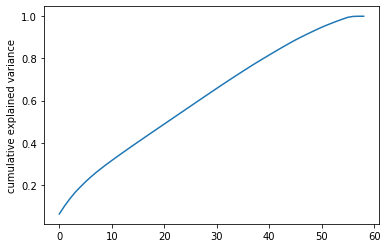

In [6]:
pca = PCA()
X = StandardScaler().fit_transform(data_LDA)
clf = pca.fit(X)
ex = -np.sort(-pca.explained_variance_ratio_)
plt.plot(np.array([i for i in range(59)]),np.cumsum(ex))
plt.ylabel('cumulative explained variance')
plt.show()

In [7]:
print(feature.shape)
print(label_LDA)
print(label)

(146317, 58)
[2 5 2 ... 2 0 2]
[0 0 0 ... 1 1 1]


In [43]:
X_train, X_test, y_train, y_test = train_test_split(feature, list(label_LDA), test_size=0.2, random_state=42)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.score(X_test,y_test)
print(clf.get_depth())
print(clf.get_n_leaves())

66
37161


In [44]:
clf = tree.DecisionTreeClassifier(max_depth = 10)
clf = clf.fit(X_train, y_train)
#tree.plot_tree(clf) 

In [45]:
clf.score(X_test, y_test)

0.5742892290869327

In [46]:
print(clf.get_depth())
print(clf.get_n_leaves())

10
527


In [12]:
columns = list(new_data.columns)[:-11]
r = export_text(clf, 
                feature_names= columns)

In [13]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=columns,
                      filled=True, rounded=True,
                                class_names = ['0','1','2','3','4','5'],
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render("../../Youth_Recidivism_Project/DecisionTree_Output/DecisionTree_commitdays, contact type, why.dot")

'../../Youth_Recidivism_Project/DecisionTree_Output/DecisionTree_commitdays, contact type, why.dot.pdf'

In [14]:
print(clf.get_n_leaves())
print(clf.get_depth())

527
10


In [15]:
path = clf.cost_complexity_pruning_path(feature, label_LDA)

Text(0, 0.5, 'total impurity of leaves')

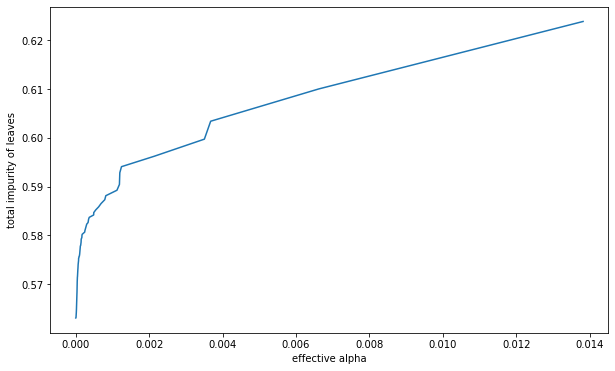

In [16]:
ccp_alphas, impurities = path.ccp_alphas, path.impurities

plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, impurities)
plt.xlabel("effective alpha")
plt.ylabel("total impurity of leaves")

In [17]:
ccp_alphas = ccp_alphas[ (ccp_alphas >= 0.0002) & (ccp_alphas <= 0.014) ]
print(len(ccp_alphas))

27


In [18]:
clfs = []

for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(feature, label_LDA)
    clfs.append(clf)
    print("done")
    

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


Text(0, 0.5, 'total depth')

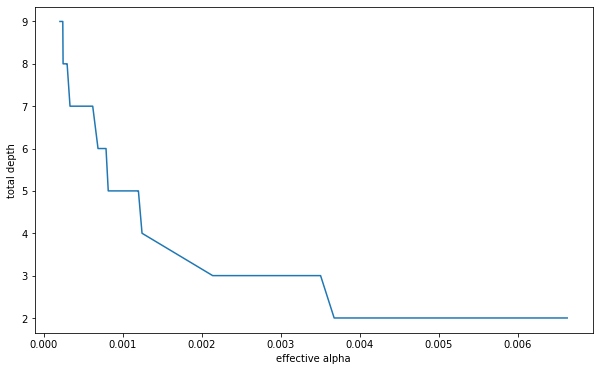

In [19]:
tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("total depth")

Text(0, 0.5, 'Accuracy scores')

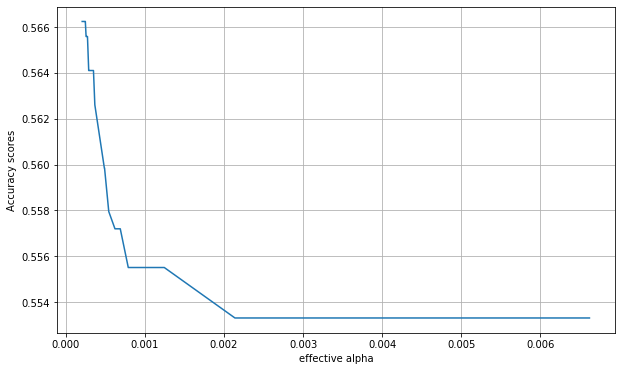

In [20]:
from sklearn.metrics import accuracy_score
acc_scores = [accuracy_score(label_LDA, clf.predict(feature)) for clf in clfs]

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], acc_scores[:-1])
plt.xlabel("effective alpha")
plt.ylabel("Accuracy scores")

In [33]:
LDA_label = label_LDA.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(LDA_label, list(label), test_size=0.2, random_state=42)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [34]:
clf.score(X_test, y_test)

0.5472594313832696

In [35]:
print(clf.get_n_leaves())
print(clf.get_depth())

6
3


In [36]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=['LDA_label'],
                      filled=True, rounded=True,
                                class_names = ['0','1'],
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render("../../Youth_Recidivism_Project/DecisionTree_Output/DecisionTree_LDA_YES.dot")

'../../Youth_Recidivism_Project/DecisionTree_Output/DecisionTree_LDA_YES.dot.pdf'

In [39]:
new_label = label.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(new_label,list(label_LDA), test_size=0.2, random_state=42)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [40]:
clf.score(X_test, y_test)

0.5421336796063423

In [41]:
print(clf.get_n_leaves())
print(clf.get_depth())

2
1


In [42]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=['YES'],
                      filled=True, rounded=True,
                                class_names = ['0','1','2','3','4','5'],
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render("../../Youth_Recidivism_Project/DecisionTree_Output/DecisionTree_YES_LDA.dot")

'../../Youth_Recidivism_Project/DecisionTree_Output/DecisionTree_YES_LDA.dot.pdf'